In [1]:
# https://keras.io/examples/nlp/text_classification_with_transformer/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np



from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
tf.__version__

'2.2.0-rc3'

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wseidel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# import re
# print(  re.sub(r'(.)\1+', r'\1', "teeeeesssssteett" ) )


def XXXX(x):
    tkn = tknzr_WordPunctTokenizer.tokenize(x.lower())
    tkn = [  re.sub(r'(.)\1+', r'\1', w )  for w in tkn if w not in stopwords and w.isalpha() and len(w) < 14 ]
#     and w.isalpha()
    if len(tkn) > 70:
        tkn = ' '.join( tkn[0:35] + ['#'] + tkn[-35:] )
    else:
        tkn = ' '.join( tkn )
    return tkn


from nltk.tokenize import TweetTokenizer
tknzr_TweetTokenizer = TweetTokenizer(strip_handles=False, reduce_len=True)

from nltk.tokenize.destructive import NLTKWordTokenizer
tknzr_NLTKWordTokenizer = NLTKWordTokenizer()

# from nltk.tokenize import MWETokenizer
# tknzr = MWETokenizer()
from nltk.tokenize import WordPunctTokenizer
tknzr_WordPunctTokenizer = WordPunctTokenizer()

from nltk.corpus import stopwords as nltk_stopwords

stopwords = nltk_stopwords.words('portuguese')
print( "Stopwords.......:", stopwords )

import re
print(  re.sub(r'(.)\1+', r'\1', "teeeeesssssteett" ) )

text = "Estou.torcendo :) poooooor: todos nós :( 12 3 7474 !! "
print( "tknzr_WordPunctTokenizer ...:", tknzr_WordPunctTokenizer.tokenize(text.lower()) )
print( "tknzr_NLTKWordTokenizer ....:", tknzr_NLTKWordTokenizer.tokenize(text.lower()) )
print( "tknzr_TweetTokenizer .......:", tknzr_TweetTokenizer.tokenize(text.lower()) )

print( "Original:\n", text )
print( "Meu pipeline .......:\n", XXXX( text ) )


# ' '.join(tknzr_WordPunctTokenizer.tokenize(text.lower()))

# import string
# s = '... some string with punctuation ...'
# s = s.translate(None, string.punctuation)

Stopwords.......: ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem',

In [39]:
# Definindo as variáveis do projeto
TAMMAX_SENTENCE =50
VOCAB_SIZE = 20000

embed_dim = 50 # tamanho do Embedding de cada token ( também do word2vec da NILC)

# Path para o arquivo de dados da b2w
B2W_DATAFILE = "/home/wseidel/workspaces/usp/b2w-reviews01/B2W-Reviews01.csv"
# B2W_DATAFILE = "/home/wesley/workspaces/usp/data/b2w/B2W-Reviews01.csv"
# B2W_DATAFILE = "/home/wseidel/workspaces/usp/b2w-reviews01/B2W-10k.csv"


# Path para o arquivo de dados de embeddings do NILC
NILC_W2V_DATAFILE = "/home/wseidel/workspaces/usp/NILC/word2vec_200k.txt"
# NILC_W2V_DATAFILE = "/home/wesley/workspaces/usp/data/nilc/word2vec_200k.txt"

In [40]:
# Carregar dados a serem analisados
b2wCorpus = pd.read_csv(B2W_DATAFILE, sep=';', usecols=["review_text", "overall_rating"])

# Carregar o Word2Vec do NILC
model_w2v = KeyedVectors.load_word2vec_format(NILC_W2V_DATAFILE)

In [48]:
def train_test_val_split(dataset, train_size=0.6, test_size=0.3, colname_stratify='overall_rating',random_seed=29):
    val_size = 1 - round((train_size + test_size),1)
    split_train_test_size = test_size + val_size

    train, val = train_test_split(dataset, 
                                  test_size=split_train_test_size, 
                                  stratify=dataset[colname_stratify], 
                                  random_state=random_seed)

    test, val = train_test_split(val, 
                                  test_size=val_size/split_train_test_size, 
                                  stratify=val[colname_stratify], 
                                  random_state=random_seed)
    return train.reset_index(drop=True), test, val

def sort_by_size(df, col_to_sort):
    df['sentence_length'] = df[col_to_sort].apply(lambda x: len(x.split()))
    df.sort_values(by=['sentence_length'], inplace=True, ignore_index=True)
    return df

def getXY(serieX, serieY, padding_maxlen=50):
#     x_train = keras.preprocessing.sequence.pad_sequences(train['review_text_clean'], maxlen=padding_maxlen, padding='post')
    x_ = serieX.values
    y_ = serieY.values
    return x_, y_



# train, test, val = train_test_val_split(df_to_work, train_size=0.75, test_size=0.15)
df_to_work = b2wCorpus

values_to_retain=[1,2,3,4,5]
df_to_work = df_to_work[df_to_work['overall_rating'].isin(values_to_retain)]
# df_to_work
df_to_work['overall_rating'] = df_to_work.overall_rating.apply(lambda x: x-1)

# # Aplicando o sentence_to_nilc_index_token
# df_to_work['review_text_clean'] = df_to_work.review_text.apply(lambda x: sentence_to_nilc_index_token(x))

def XXXX(x):
    tkn = tknzr_WordPunctTokenizer.tokenize(x.lower())
#     tkn = [  re.sub(r'(.)\1+', r'\1', w )  for w in tkn if w not in stopwords and w.isalpha() and len(w) < 14 ]
    tkn = [  re.sub(r'(.)\1+', r'\1', w )  for w in tkn ]
#     and w.isalpha()
#     if len(tkn) > 70:
#         tkn = ' '.join( tkn[0:35] + ['#'] + tkn[-35:] )
#     else:
    tkn = ' '.join( tkn )
    return tkn



# df_to_work['review_text'] = df_to_work.review_text.apply(lambda x: ' '.join( tknzr_WordPunctTokenizer.tokenize(x.lower()) ))
df_to_work['review_text'] = df_to_work.review_text.apply(lambda x: XXXX(x) )

train, test, val = train_test_val_split(df_to_work)

sort_by_size(train, 'review_text')


x_train, y_train = getXY(train['review_text'], train['overall_rating'])
x_test,  y_test  = getXY(test['review_text'], test['overall_rating'])
x_val,   y_val   = getXY(val['review_text'], val['overall_rating'])


print("train..:", len(train), round(len(train) / len(df_to_work),3) ) 
print("test...:", len(test), round(len(test) / len(df_to_work),3) )
print("val....:", len(val), round(len(val) / len(df_to_work),3) )
print("--" * 20) 
print("x_train..:", len(x_train), "Last value(Y,X)..: [", y_train[-1], "] ", x_train[-1] )
print("x_train..:", len(x_train), "Last value(Y,X)..: [", y_train[-10], "] ", x_train[-10] )
print("x_test...:", len(x_test),  "Last value(Y,X)..: [", y_test[-1], "] ", x_test[-1] )
print("x_val....:", len(x_val),  "Last value(Y,X)..: [", y_val[-1], "] ", x_val[-1] )

train..: 79423 0.6
test...: 39712 0.3
val....: 13238 0.1
----------------------------------------
x_train..: 79423 Last value(Y,X)..: [ 2 ]  pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto p

In [49]:
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens= VOCAB_SIZE,#MAX_TOKENS,
    standardize= 'lower_and_strip_punctuation', # None
#     standardize=None,
    output_mode='int', # "int", "binary", "count" or "tf-idf",
    output_sequence_length= TAMMAX_SENTENCE  # Only valid in INT mode.
)

vectorize_layer.adapt(x_train)

/home/wseidel/virtualenvs/mac5725-NLP/lib/python3.8/site-packages/tensorflow/python/keras/layers/preprocessing/text_vectorization.py:338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(preprocessed_data.to_list())


In [50]:
# vectorize_layer.get_vocabulary()[0]
print(  vectorize_layer([["vamos a la , poor sim e o a vamos.a"]]) )
print(  len( vectorize_layer([["vamos a la , poor sim e o a vamos.a"]])[0]) )

# voc = vectorize_layer.get_vocabulary()
# word_index = dict(zip(voc, range(2,len(voc))))
# print( word_index.get(b'e',1) )

tf.Tensor(
[[938   4 764   1 306   2   3   4   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)
50


In [51]:
word = 'ewe'
print(word in model_w2v.vocab)
# print(model_w2v.vocab.get( word ))
# print(model_w2v.get_vector( word ))
print(model_w2v[ word ])

True
[ 0.327817 -0.046486 -0.035211  0.336974  0.222097  0.233713 -0.162169
  0.149764  0.05723  -0.514274  0.166825 -0.277698 -0.0505    0.129016
  0.323467  0.192564  0.254657  0.044863 -0.424474 -0.06145  -0.003705
 -0.074031  0.155225  0.177354 -0.041996 -0.121522  0.140458  0.374408
  0.17874   0.252357  0.357419  0.345899 -0.210592  0.042722 -0.249315
 -0.229042  0.052943  0.107606 -0.310207  0.05263  -0.27051   0.091217
  0.098549  0.343337  0.262118 -0.141338  0.236483 -0.252186 -0.373523
  0.326753]


In [52]:
# https://keras.io/examples/nlp/pretrained_word_embeddings/#create-a-vocabulary-index
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(2,len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word.decode('UTF-8') in model_w2v.vocab:
        embedding_matrix[i] = model_w2v[ word.decode('UTF-8') ]
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

nilc_embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# word_index
# embedding_matrix

Converted 16202 words (3795 misses)


In [53]:

def get_model(vocab_size=1000, dropout_prob=0.0):
#     embedding_layer = model_w2v.get_keras_embedding()
#     embedding_layer.trainable = True

    model = keras.Sequential()
#     model.add(layers.Input(shape=(TAMMAX_SENTENCE, )))
    model.add(layers.Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(layers.Embedding(vocab_size+1, 50, input_length=TAMMAX_SENTENCE))
#     model.add(nilc_embedding_layer)
#     model.add(embedding_layer)
    model.add(layers.LSTM(32))
    
#     model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dropout(dropout_prob))
    model.add(keras.layers.Dense(5, activation='softmax'))
    
    return model

model = get_model( vocab_size=VOCAB_SIZE, dropout_prob=0)

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, 50)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 50, 50)            1000050   
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                10624     
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 165       
Total params: 1,010,839
Trainable params: 1,010,839
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Exemplo a implementar
# name = 'm1_lstm_drop0.0'
# model = get_lstm_model(dropout_prob=0.5)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# mc = ModelCheckpoint('../model_data/' + name + 'best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), callbacks=[es, mc])
# save_history(history, name)
# model.evaluate(x_test, y_test)
# display_loss_plot(history, name)
# display_acc_plot(history, name)
VOCAB_SIZE

20000

In [108]:
# Ver lista06

# Ler aqui pro batch generator:
#     https://datascience.stackexchange.com/questions/48796/how-to-feed-lstm-with-different-input-array-sizes

# Seu código aqui

QNT_EPOCAS_TREINO = 10

history = model.fit(
    x_train, y_train, 
    batch_size=32, 
    epochs=QNT_EPOCAS_TREINO, 
    validation_data=(x_val, y_val)
)

loss, accuracy = model.evaluate(x=x_test,y=y_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/10
  71/2482 [..............................] - ETA: 1:21 - loss: 0.6197 - accuracy: 0.7302

KeyboardInterrupt: 

# Comparações 

## configs:
 - LSTM = 32
 - vocab_size = 1000
 - Embeddind = Zerado
 - Tokenizer padrão do TextVectorization
    
```
Epoch 1/3
2482/2482 [==============================] - 53s 21ms/step - loss: 1.0628 - accuracy: 0.5413 - val_loss: 0.9851 - val_accuracy: 0.5830
Epoch 2/3
2482/2482 [==============================] - 54s 22ms/step - loss: 0.9624 - accuracy: 0.5881 - val_loss: 0.9556 - val_accuracy: 0.5934
Epoch 3/3
2482/2482 [==============================] - 53s 21ms/step - loss: 0.9346 - accuracy: 0.5976 - val_loss: 0.9435 - val_accuracy: 0.5968
1241/1241 [==============================] - 8s 7ms/step - loss: 0.9454 - accuracy: 0.5933
Loss:  0.9453516602516174
Accuracy:  0.5933470726013184
```

## configs:
 - LSTM = 32
 - vocab_size = 1000
 - Embeddind = Zerado
 - tknzr_WordPunctTokenizer (NLTK) + Tokenizer padrão do TextVectorization 
    
```
Epoch 1/10
2482/2482 [==============================] - 56s 23ms/step - loss: 1.0530 - accuracy: 0.5473 - val_loss: 0.9864 - val_accuracy: 0.5678
Epoch 2/10
2482/2482 [==============================] - 54s 22ms/step - loss: 0.9563 - accuracy: 0.5878 - val_loss: 0.9343 - val_accuracy: 0.5979
Epoch 3/10
2482/2482 [==============================] - 53s 21ms/step - loss: 0.9300 - accuracy: 0.5993 - val_loss: 0.9297 - val_accuracy: 0.6015
Epoch 4/10
2482/2482 [==============================] - 53s 21ms/step - loss: 0.9099 - accuracy: 0.6064 - val_loss: 0.9220 - val_accuracy: 0.6045
Epoch 5/10
2482/2482 [==============================] - 53s 22ms/step - loss: 0.8970 - accuracy: 0.6103 - val_loss: 0.9292 - val_accuracy: 0.6044
Epoch 6/10
2482/2482 [==============================] - 53s 21ms/step - loss: 0.8835 - accuracy: 0.6147 - val_loss: 0.9215 - val_accuracy: 0.6052
Epoch 7/10
2482/2482 [==============================] - 53s 21ms/step - loss: 0.8728 - accuracy: 0.6192 - val_loss: 0.9154 - val_accuracy: 0.6067
Epoch 8/10
2482/2482 [==============================] - 54s 22ms/step - loss: 0.8627 - accuracy: 0.6230 - val_loss: 0.9170 - val_accuracy: 0.6066
Epoch 9/10
2482/2482 [==============================] - 54s 22ms/step - loss: 0.8527 - accuracy: 0.6287 - val_loss: 0.9211 - val_accuracy: 0.6039
Epoch 10/10
2482/2482 [==============================] - 55s 22ms/step - loss: 0.8437 - accuracy: 0.6312 - val_loss: 0.9213 - val_accuracy: 0.6039
1241/1241 [==============================] - 8s 7ms/step - loss: 0.9257 - accuracy: 0.6052
Loss:  0.9256511330604553
Accuracy:  0.6052075028419495
```

## configs:
 - LSTM = 32
 - vocab_size = 20000
 - Embeddind = NILC (Feito de outra maneira e com Treinable desligado)
 - tknzr_WordPunctTokenizer (NLTK) + Tokenizer padrão do TextVectorization 

```
Epoch 1/10
2482/2482 [==============================] - 60s 24ms/step - loss: 1.1687 - accuracy: 0.5054 - val_loss: 1.0666 - val_accuracy: 0.5375
Epoch 2/10
2482/2482 [==============================] - 64s 26ms/step - loss: 1.0500 - accuracy: 0.5513 - val_loss: 1.0184 - val_accuracy: 0.5625
Epoch 3/10
2482/2482 [==============================] - 64s 26ms/step - loss: 1.0097 - accuracy: 0.5681 - val_loss: 0.9957 - val_accuracy: 0.5730
Epoch 4/10
2482/2482 [==============================] - 61s 25ms/step - loss: 0.9862 - accuracy: 0.5797 - val_loss: 0.9679 - val_accuracy: 0.5847
Epoch 5/10
2482/2482 [==============================] - 60s 24ms/step - loss: 0.9692 - accuracy: 0.5842 - val_loss: 0.9723 - val_accuracy: 0.5829
Epoch 6/10
2482/2482 [==============================] - 61s 25ms/step - loss: 0.9584 - accuracy: 0.5894 - val_loss: 0.9547 - val_accuracy: 0.5925
Epoch 7/10
2482/2482 [==============================] - 60s 24ms/step - loss: 0.9485 - accuracy: 0.5919 - val_loss: 0.9628 - val_accuracy: 0.5922
Epoch 8/10
2482/2482 [==============================] - 61s 24ms/step - loss: 0.9390 - accuracy: 0.5962 - val_loss: 0.9481 - val_accuracy: 0.5935
Epoch 9/10
2482/2482 [==============================] - 62s 25ms/step - loss: 0.9314 - accuracy: 0.5978 - val_loss: 0.9411 - val_accuracy: 0.5962
Epoch 10/10
2482/2482 [==============================] - 62s 25ms/step - loss: 0.9253 - accuracy: 0.6001 - val_loss: 0.9555 - val_accuracy: 0.5919
1241/1241 [==============================] - 11s 9ms/step - loss: 0.9570 - accuracy: 0.5886
Loss:  0.9570415019989014
Accuracy:  0.5885878205299377
```

## configs:
 - LSTM = 32
 - vocab_size = 20000
 - Embeddind = NILC (Feito de outra maneira e com Treinable LIGADO)
 - tknzr_WordPunctTokenizer (NLTK) + Tokenizer padrão do TextVectorization 
 - Dropout = 0

```
Epoch 1/10
2482/2482 [==============================] - 92s 37ms/step - loss: 1.0463 - accuracy: 0.5476 - val_loss: 0.9601 - val_accuracy: 0.5870
Epoch 2/10
2482/2482 [==============================] - 93s 38ms/step - loss: 0.9105 - accuracy: 0.6058 - val_loss: 0.9235 - val_accuracy: 0.6042
Epoch 3/10
2482/2482 [==============================] - 100s 40ms/step - loss: 0.8504 - accuracy: 0.6326 - val_loss: 0.9225 - val_accuracy: 0.6120
Epoch 4/10
2482/2482 [==============================] - 97s 39ms/step - loss: 0.8035 - accuracy: 0.6549 - val_loss: 0.9515 - val_accuracy: 0.6067
Epoch 5/10
2482/2482 [==============================] - 96s 39ms/step - loss: 0.7576 - accuracy: 0.6777 - val_loss: 0.9500 - val_accuracy: 0.5953
Epoch 6/10
2482/2482 [==============================] - 95s 38ms/step - loss: 0.7131 - accuracy: 0.6990 - val_loss: 0.9918 - val_accuracy: 0.5965
Epoch 7/10
2482/2482 [==============================] - 97s 39ms/step - loss: 0.6657 - accuracy: 0.7206 - val_loss: 1.0642 - val_accuracy: 0.5860
Epoch 8/10
2482/2482 [==============================] - 96s 39ms/step - loss: 0.6215 - accuracy: 0.7393 - val_loss: 1.1474 - val_accuracy: 0.5801
Epoch 9/10
2482/2482 [==============================] - 97s 39ms/step - loss: 0.5775 - accuracy: 0.7580 - val_loss: 1.2161 - val_accuracy: 0.5840
Epoch 10/10
2482/2482 [==============================] - 97s 39ms/step - loss: 0.5411 - accuracy: 0.7742 - val_loss: 1.2183 - val_accuracy: 0.5745
1241/1241 [==============================] - 10s 8ms/step - loss: 1.2242 - accuracy: 0.5756
Loss:  1.2242217063903809
Accuracy:  0.5756446123123169
```
## configs:
 - LSTM = 64
 - vocab_size = 20000
 - Embeddind = NILC (Feito de outra maneira e com Treinable LIGADO)
 - tknzr_WordPunctTokenizer (NLTK) + Tokenizer padrão do TextVectorization 

```
Epoch 1/10
2482/2482 [==============================] - 103s 42ms/step - loss: 1.0366 - accuracy: 0.5525 - val_loss: 0.9720 - val_accuracy: 0.5856
Epoch 2/10
2482/2482 [==============================] - 115s 46ms/step - loss: 0.9052 - accuracy: 0.6089 - val_loss: 0.9280 - val_accuracy: 0.5956
Epoch 3/10
2482/2482 [==============================] - 108s 43ms/step - loss: 0.8453 - accuracy: 0.6339 - val_loss: 0.9224 - val_accuracy: 0.6061
Epoch 4/10
2482/2482 [==============================] - 110s 44ms/step - loss: 0.7957 - accuracy: 0.6572 - val_loss: 0.9449 - val_accuracy: 0.6036
Epoch 5/10
2482/2482 [==============================] - 108s 43ms/step - loss: 0.7469 - accuracy: 0.6807 - val_loss: 1.0051 - val_accuracy: 0.6020
Epoch 6/10
2482/2482 [==============================] - 111s 45ms/step - loss: 0.6993 - accuracy: 0.7023 - val_loss: 1.0211 - val_accuracy: 0.5981
Epoch 7/10
2482/2482 [==============================] - 110s 44ms/step - loss: 0.6487 - accuracy: 0.7240 - val_loss: 1.0579 - val_accuracy: 0.5919
Epoch 8/10
2482/2482 [==============================] - 130s 52ms/step - loss: 0.6005 - accuracy: 0.7453 - val_loss: 1.1243 - val_accuracy: 0.5855
Epoch 9/10
2482/2482 [==============================] - 143s 57ms/step - loss: 0.5544 - accuracy: 0.7647 - val_loss: 1.1872 - val_accuracy: 0.5789
Epoch 10/10
2482/2482 [==============================] - 132s 53ms/step - loss: 0.5115 - accuracy: 0.7823 - val_loss: 1.3067 - val_accuracy: 0.5838
1241/1241 [==============================] - 13s 11ms/step - loss: 1.3269 - accuracy: 0.5763
Loss:  1.3268840312957764
Accuracy:  0.5762741565704346
```
## configs:
 - LSTM = 64
 - vocab_size = 2000
 - Embeddind = Zerado
 - tknzr_WordPunctTokenizer (NLTK) + Tokenizer padrão do TextVectorization 
 - Dropout = 0
 - Tammax:25
 
```
Epoch 1/10
2482/2482 [==============================] - 83s 34ms/step - loss: 1.0459 - accuracy: 0.5484 - val_loss: 0.9820 - val_accuracy: 0.5829
Epoch 2/10
2482/2482 [==============================] - 85s 34ms/step - loss: 0.9326 - accuracy: 0.5994 - val_loss: 0.9315 - val_accuracy: 0.6042
Epoch 3/10
2482/2482 [==============================] - 94s 38ms/step - loss: 0.8885 - accuracy: 0.6159 - val_loss: 0.9248 - val_accuracy: 0.5943
Epoch 4/10
2482/2482 [==============================] - 105s 42ms/step - loss: 0.8573 - accuracy: 0.6284 - val_loss: 0.9050 - val_accuracy: 0.6096
Epoch 5/10
2482/2482 [==============================] - 86s 35ms/step - loss: 0.8309 - accuracy: 0.6386 - val_loss: 0.9211 - val_accuracy: 0.6080
Epoch 6/10
2482/2482 [==============================] - 86s 35ms/step - loss: 0.8065 - accuracy: 0.6493 - val_loss: 0.9200 - val_accuracy: 0.6098
Epoch 7/10
2482/2482 [==============================] - 86s 35ms/step - loss: 0.7834 - accuracy: 0.6604 - val_loss: 0.9367 - val_accuracy: 0.6051
Epoch 8/10
2482/2482 [==============================] - 87s 35ms/step - loss: 0.7579 - accuracy: 0.6720 - val_loss: 0.9501 - val_accuracy: 0.6042
Epoch 9/10
2482/2482 [==============================] - 88s 35ms/step - loss: 0.7347 - accuracy: 0.6846 - val_loss: 0.9652 - val_accuracy: 0.6054
Epoch 10/10
2482/2482 [==============================] - 90s 36ms/step - loss: 0.7092 - accuracy: 0.6944 - val_loss: 1.0024 - val_accuracy: 0.6018
1241/1241 [==============================] - 13s 10ms/step - loss: 1.0161 - accuracy: 0.5920
Loss:  1.0161194801330566
Accuracy:  0.5919873118400574
```

## configs:
 - LSTM = 64
 - vocab_size = 2000
 - Embeddind = Zerado
 - tknzr_WordPunctTokenizer (NLTK) + Tokenizer padrão do TextVectorization 
 - Dropout = 0.5
 - Tammax:25

```
Epoch 1/10
2482/2482 [==============================] - 43s 17ms/step - loss: 1.0446 - accuracy: 0.5565 - val_loss: 0.9762 - val_accuracy: 0.5910
Epoch 2/10
2482/2482 [==============================] - 47s 19ms/step - loss: 0.9586 - accuracy: 0.5923 - val_loss: 0.9584 - val_accuracy: 0.5853
Epoch 3/10
2482/2482 [==============================] - 44s 18ms/step - loss: 0.9314 - accuracy: 0.6004 - val_loss: 0.9345 - val_accuracy: 0.6022
Epoch 4/10
2482/2482 [==============================] - 44s 18ms/step - loss: 0.9061 - accuracy: 0.6085 - val_loss: 0.9289 - val_accuracy: 0.6000
Epoch 5/10
2482/2482 [==============================] - 45s 18ms/step - loss: 0.8868 - accuracy: 0.6159 - val_loss: 0.9281 - val_accuracy: 0.6047
Epoch 6/10
2482/2482 [==============================] - 46s 18ms/step - loss: 0.8701 - accuracy: 0.6231 - val_loss: 0.9364 - val_accuracy: 0.5907
Epoch 7/10
2482/2482 [==============================] - 49s 20ms/step - loss: 0.8545 - accuracy: 0.6294 - val_loss: 0.9483 - val_accuracy: 0.6015
Epoch 8/10
2482/2482 [==============================] - 41s 17ms/step - loss: 0.8393 - accuracy: 0.6362 - val_loss: 0.9482 - val_accuracy: 0.6005
Epoch 9/10
2482/2482 [==============================] - 45s 18ms/step - loss: 0.8253 - accuracy: 0.6402 - val_loss: 0.9591 - val_accuracy: 0.5960
Epoch 10/10
2482/2482 [==============================] - 46s 18ms/step - loss: 0.8108 - accuracy: 0.6465 - val_loss: 0.9692 - val_accuracy: 0.5933
1241/1241 [==============================] - 8s 6ms/step - loss: 0.9718 - accuracy: 0.5920
Loss:  0.9717921018600464
Accuracy:  0.5919873118400574
```


## configs:
 - LSTM = 64
 - vocab_size = 2000
 - Embeddind = Zerado
 - tknzr_WordPunctTokenizer (NLTK) + Tokenizer padrão do TextVectorization 
 - Dropout = 0.5
 - Tammax:50 ( 25 primeiros + 25 ultimos)


```
Epoch 1/10
2482/2482 [==============================] - 45s 18ms/step - loss: 1.0365 - accuracy: 0.5614 - val_loss: 0.9619 - val_accuracy: 0.5950
Epoch 2/10
2482/2482 [==============================] - 50s 20ms/step - loss: 0.9580 - accuracy: 0.5932 - val_loss: 0.9520 - val_accuracy: 0.5910
Epoch 3/10
2482/2482 [==============================] - 45s 18ms/step - loss: 0.9325 - accuracy: 0.6020 - val_loss: 0.9407 - val_accuracy: 0.5984
Epoch 4/10
2482/2482 [==============================] - 48s 19ms/step - loss: 0.9092 - accuracy: 0.6091 - val_loss: 0.9357 - val_accuracy: 0.6039
Epoch 5/10
2482/2482 [==============================] - 44s 18ms/step - loss: 0.8906 - accuracy: 0.6157 - val_loss: 0.9351 - val_accuracy: 0.5997
Epoch 6/10
2482/2482 [==============================] - 48s 19ms/step - loss: 0.8749 - accuracy: 0.6238 - val_loss: 0.9310 - val_accuracy: 0.6036
Epoch 7/10
2482/2482 [==============================] - 46s 18ms/step - loss: 0.8602 - accuracy: 0.6275 - val_loss: 0.9314 - val_accuracy: 0.6038
Epoch 8/10
2482/2482 [==============================] - 46s 19ms/step - loss: 0.8447 - accuracy: 0.6341 - val_loss: 0.9387 - val_accuracy: 0.6005
Epoch 9/10
2482/2482 [==============================] - 50s 20ms/step - loss: 0.8321 - accuracy: 0.6396 - val_loss: 0.9681 - val_accuracy: 0.5988
Epoch 10/10
2482/2482 [==============================] - 49s 20ms/step - loss: 0.8171 - accuracy: 0.6460 - val_loss: 0.9611 - val_accuracy: 0.5992
1241/1241 [==============================] - 8s 6ms/step - loss: 0.9662 - accuracy: 0.5934
Loss:  0.9661514759063721
Accuracy:  0.5933974385261536
```

In [57]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# y_pred[0]
# y_test[0]

In [72]:
print(''.join([ l.name + '\n' for l in  model.layers ]))

text_vectorization_3
embedding_12
lstm_10
dropout_10
dense_10



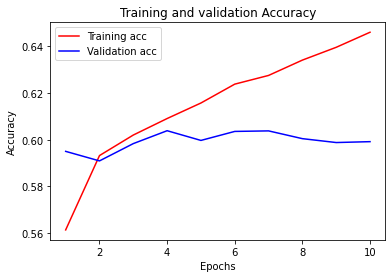

In [36]:
# 
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.savefig('LSTM:64_Embeddind:Zerado_Vocab:2000_tknzr:WordPunctTokenizer_Accuracy_TamMax:50PU_Accuracy.jpg')
plt.show()

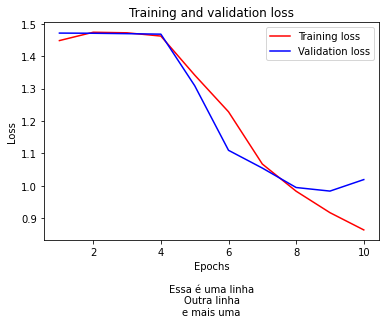

In [59]:
text  = "\n\nEssa é uma linha\n"
text += "Outra linha\n"
text += "e mais uma\n"

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs' + text)
plt.ylabel('Loss')
plt.legend()
# plt.xlabel('this is a xlabel\n(with newlines!)')

# plt.savefig('LSTM:64_Embeddind:Zerado_Vocab:2000_tknzr:WordPunctTokenizer_Accuracy_TamMax:50PU_Loss.jpg')
# plt.savefig('LSTM:64_Embeddind:Zerado_Vocab:2000_tknzr:WordPunctTokenizer_Accuracy_TamMax:50PU_Loss.jpg')
plt.show()

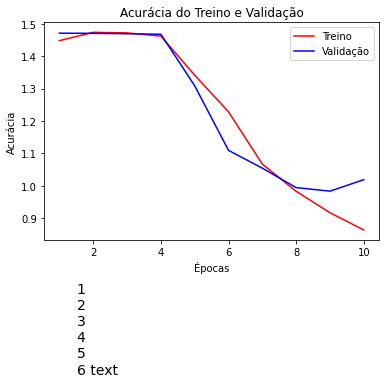

_text_vectorization_3_embedding_12_lstm_10_dropout_10_dense_10_


In [107]:
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': False})


def renderfig( file, line1, line2, label1, label2, title, xlabel, ylabel, text ):
    epochs = range(1, len(line1) + 1)
    plt.plot(epochs, line1, 'r', label=label1)
    plt.plot(epochs, line2, 'b', label=label2)
    plt.title(title)
    plt.xlabel(xlabel )
    plt.ylabel(ylabel)
    plt.legend()
#     plt.figtext(0.5, -0.5, "1\n2\n3\n4\n5\n6 text", ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.2, -0.34, "1\n2\n3\n4\n5\n6 text",  fontsize=14)
#     plt.tight_layout()
#         plt.savefig(file, bbox_inches = "tight")
#     plt.close('all')
    plt.show()
#     plt.savefig('xxx_Accuracy.jpg')

# text  = "\n\nEssa é uma linha\n"
# text += "Outra linha\n"
# text += "e mais uma\n"
text = '\n'+''.join([ l.name + '\n' for l in  model.layers ])

# renderfig( 'xxx_Accuracy.jpg', acc , val_acc , "Treino", "Validação", "Acurácia do Treino e Validação", "Épocas", "Acurácia", text )
renderfig( 'xxx_Accuracy.jpg', loss , val_loss , "Treino", "Validação", "Acurácia do Treino e Validação", "Épocas", "Acurácia", text )

print(text.replace("\n","_"))
# plt.figtext(0.5, 0.01, "one text and next text", ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})